In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow.keras import models, layers, Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

from sklearn.feature_extraction.text import CountVectorizer

from Code.utils.dataset import Dataset

[nltk_data] Downloading package punkt to C:\Users\Guilherme
[nltk_data]     Barbosa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def build_model(hp):
    min_hidden = 2
    max_hidden = 16

    model = models.Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    hp1_units = hp.Int('hidden1_units', min_value=min_hidden, max_value=max_hidden, step=2)
    model.add(SimpleRNN(hp1_units, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    #compilar modelo
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
    hp_momentum = hp.Choice('momentum', values=[0.001, 0.005, 0.01])
    optimizer = SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model

In [3]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

# Remover pontuação deu pior resultado
X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)

In [4]:
# Start tuner

tuner = kt.Hyperband(
    build_model,
    objective='acc',
    max_epochs=10,
    factor=3,
    directory='./KerasTuner',  # Directory to store results
    project_name='RNN_Tuning_1_Layers'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Reloading Tuner from ./KerasTuner\RNN_Tuning\tuner0.json


Hidden Layer 1 has 16 units
Optimizer learning rate = 0.01
Optimizer momentum = 0.01
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - acc: 0.5398 - loss: 0.6871 - val_acc: 0.6080 - val_loss: 0.6713
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6169 - loss: 0.6676 - val_acc: 0.6160 - val_loss: 0.6617
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6268 - loss: 0.6579 - val_acc: 0.6210 - val_loss: 0.6531
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6495 - loss: 0.6465 - val_acc: 0.6260 - val_loss: 0.6450
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6476 - loss: 0.6391 - val_acc: 0.6330 - val_loss: 0.6371
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6619 - loss: 0.6270 - val_acc: 0.6430 - val_loss: 0.6300
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6704 - loss: 0.6215 - val_acc: 0.6480 - val_loss: 0.6233
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.6646 - loss: 0.6212 

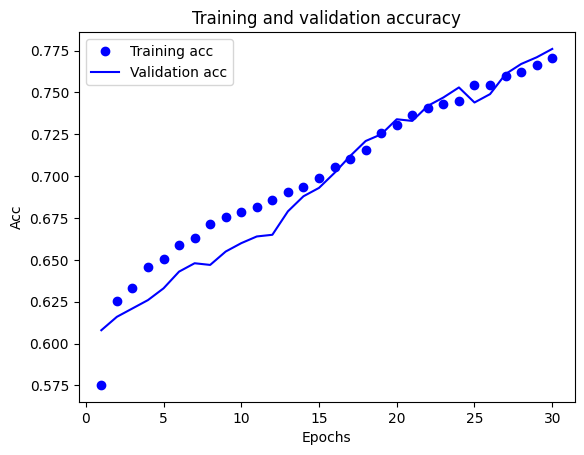

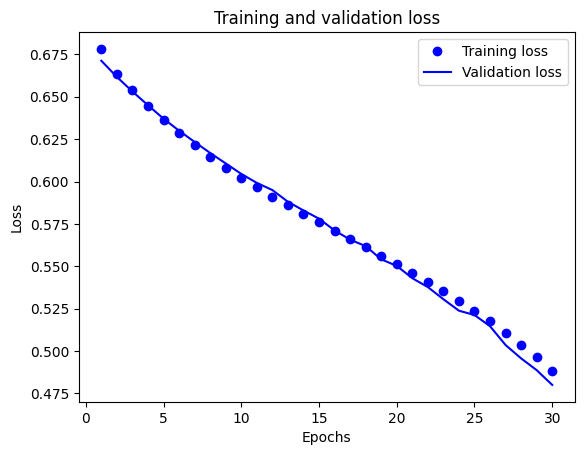

[0.49374866485595703, 0.7710000276565552]

In [5]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_features = X_train.shape[1]

hidden1_units = best_hps['hidden1_units']
learning_rate = best_hps['learning_rate']
momentum = best_hps['momentum']

print(f"Hidden Layer 1 has {hidden1_units} units")
print(f"Optimizer learning rate = {learning_rate}")
print(f"Optimizer momentum = {momentum}")

model = models.Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(hidden1_units, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

#compilar modelo
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model
results = model.evaluate(X_test, y_test, verbose = 0)
results

In [8]:
# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - acc: 0.6667 - loss: 0.6536
[0.6536160111427307, 0.6666666865348816]


In [21]:
# Store results

results_filepath = './Results/rnn_tuner_1_layers_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(results_filepath, sep='\t', index=False)

In [7]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)